In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import shapiro

In [2]:
data_combined = pd.read_csv('./Datasets/combined_loans.csv')

In [3]:
data_combined.head()

,loan_amnt,dti,zip_code,addr_state,emp_length,year,loan_status,title_category
0,3600.0,5.91,190xx,PA,10+ years,2015.0,1,Debt Consolidation
1,24700.0,16.06,577xx,SD,10+ years,2015.0,1,Business
2,20000.0,10.78,605xx,IL,10+ years,2015.0,1,NaN
3,35000.0,17.06,076xx,NJ,10+ years,2015.0,1,Debt Consolidation
4,10400.0,25.37,174xx,PA,3 years,2015.0,1,Major Purchase


In [4]:
data_combined.shape

(29909442, 8)

- More than 29 milion data instances. 8 features.

## Missing values

In [5]:
missing_values = data_combined.isnull().sum()
print(missing_values)

loan_amnt              33
dti                  1744
zip_code              327
addr_state             55
emp_length        1098295
year                   33
loan_status             0
title_category     163132
dtype: int64


- Compared to total amount of data, these missing values don't represent substantial parts of data. 

In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [7]:
data_combined.describe()

,loan_amnt,dti,year,loan_status
count,29909409.00,29907698.00,29909409.00,29909442.00
mean,13277.88,133.94,2016.43,0.08
std,14659.49,10133.39,1.68,0.26
min,0.00,-1.00,2007.00,0.00
25%,5000.00,8.55,2016.00,0.00
50%,10000.00,19.68,2017.00,0.00
75%,20000.00,35.10,2018.00,0.00
max,1400000.00,50000031.49,2018.00,1.00


- loan_amnt (Loan Amount):

    - Count: 29,909,409 entries.
    - Mean: The average loan amount is approximately 13,278.
    - Standard Deviation: There's a wide range in loan amounts, with a standard deviation of approximately 14,660, indicating significant variability.
    - Min/Max: Loan amounts range from 0 to 1,400,000.
    - Quartiles: 25% of loans are 5,000 or less, 50% are 10,000 or less (median), and 75% are 20,000 or less.

---
- dti (Debt-to-Income Ratio):
    - Count: 29,907,698 entries.
    - Mean: The average DTI is approximately 134, but this number is unusually high for a typical debt-to-income ratio, suggesting possible outliers or data entry errors.
    - Standard Deviation: Extremely high at about 10,133, indicating significant anomalies or errors in data.
    - Min/Max: Ranges from -1 (which is an invalid value for DTI) to over 50,000,031, which is extraordinarily high for DTI.
    - Quartiles: 25% of DTIs are 8.55 or lower, 50% are 19.68 or lower (median), and 75% are 35.1 or lower.

---

- year:
    - Count: 29,909,409 entries.
    - Mean: The average year is approximately 2016, suggesting that most data is from recent years.
    - Standard Deviation: About 1.68, indicating that the data spans a few years around the mean.
    - Min/Max: Data ranges from 2007 to 2018.
    - Quartiles: 25% of the data is from 2016 or earlier, 50% from 2017 or earlier, and 75% from 2018 or earlier.


---
- loan_status:
    - Count: 29,909,442 entries.
    - Mean: The average value is 0.08, suggesting that a small percentage of loans have a specific status (likely indicating default or a similar issue, if '1' represents a negative status).
    - Standard Deviation: 0.26, indicating that most loans are likely in a 'normal' status, with a small proportion in the alternative status.
    - Min/Max: Values range from 0 to 1, indicating this is likely a binary indicator (e.g., 0 for normal, 1 for default).
    - Quartiles: Since the 25th, 50th, and 75th percentiles are all 0, the majority of loans are in the 'normal' status, with a small proportion in the alternative status.

## Visualizations and grouping

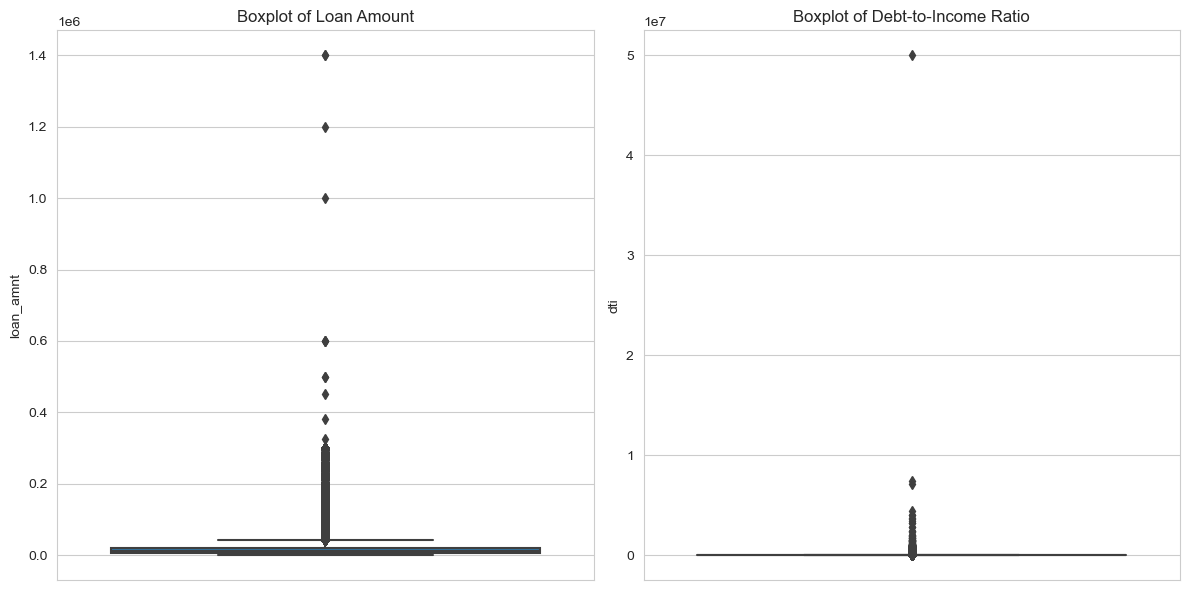

In [8]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=data_combined['loan_amnt'])
plt.title('Boxplot of Loan Amount')

plt.subplot(1, 2, 2)
sns.boxplot(y=data_combined['dti'])
plt.title('Boxplot of Debt-to-Income Ratio')

plt.tight_layout()
plt.show()

- We can really see how extreme some values are. Very large spectrum of values.

In [9]:
sampled_data = data_combined.sample(n=50000, random_state=1) 

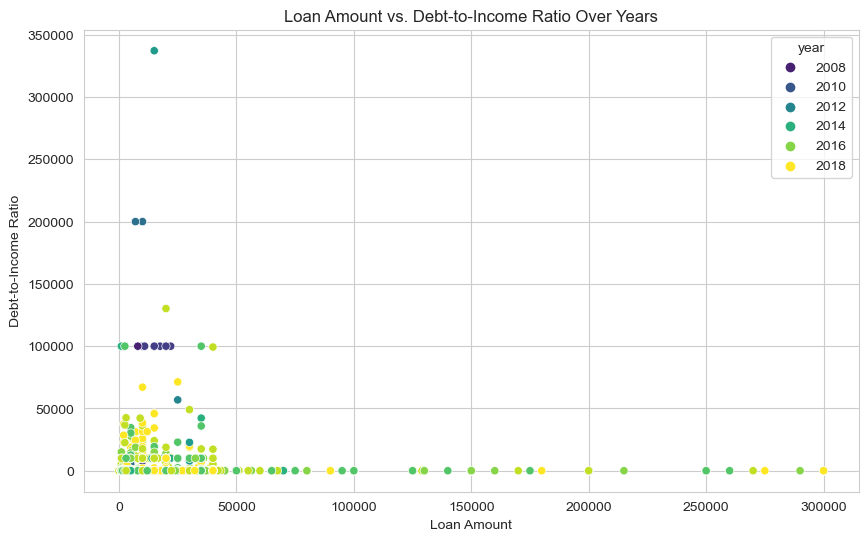

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='loan_amnt', y='dti', hue='year', palette='viridis', data=sampled_data)
plt.title("Loan Amount vs. Debt-to-Income Ratio Over Years")
plt.xlabel("Loan Amount")
plt.ylabel("Debt-to-Income Ratio")
plt.show()

- We can clearly see higher the dti, lower the loan amount. 
- With no higher dti above arround 50000 loan amount.

C:\Users\Martin\AppData\Local\Temp\ipykernel_25632\1455876305.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sampled_data['loan_amnt'], shade=True)


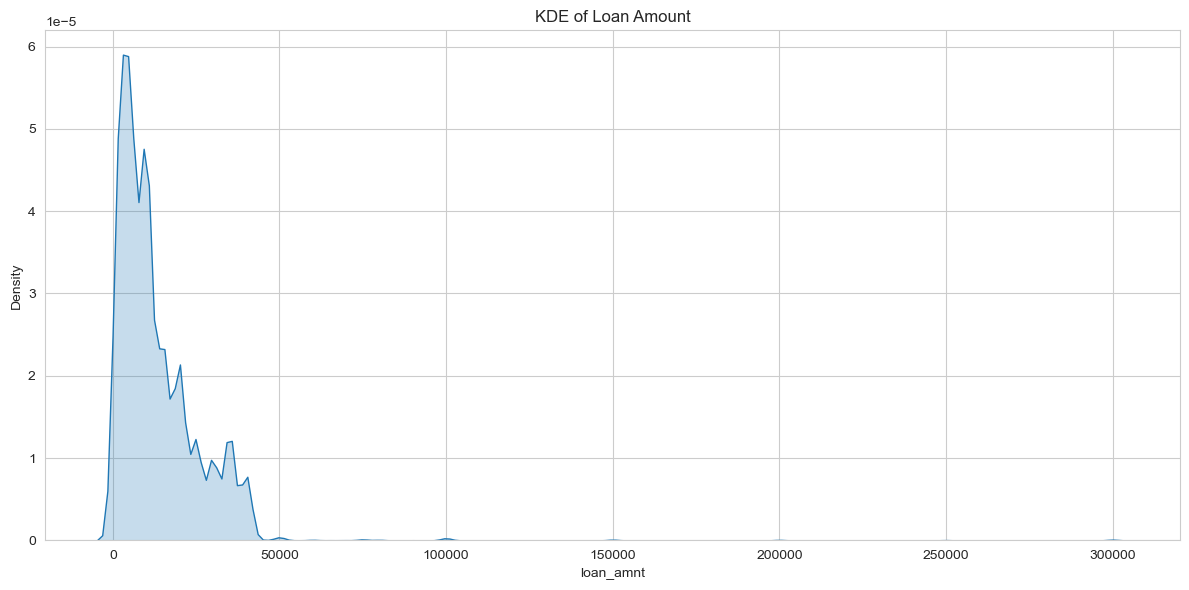

In [11]:
plt.figure(figsize=(12, 6))
sns.kdeplot(sampled_data['loan_amnt'], shade=True)
plt.title('KDE of Loan Amount')
plt.tight_layout()
plt.show()

- We can see loan amounts in more detail, primary loian range between 0-50,000

## Data aggregation and functions by year

In [12]:
def mode(x):
    return x.mode().iloc[0] if len(x) > 0 else None

def count_accepted(x):
    return (x == 1).sum()

def count_rejected(x):
    return (x == 0).sum()

agg_funcs = {
    'emp_length': mode,          
    'loan_status': [count_accepted, count_rejected],  
    'loan_amnt': ['sum', 'mean', 'std'], 
    'dti': ['mean', 'std'],        
    'title_category': mode        
}

result = data_combined.groupby('year').agg(agg_funcs)
result.columns = ['emp_length_mode',
                  'accepted_count',
                  'rejected_count',
                  'loan_amnt_sum',
                  'loan_amnt_mean',
                  'loan_amnt_std', 'dti_mean',
                  'dti_std'
                  , 'title_category_mode']
result = result.reset_index()

In [13]:
result['year'] = result['year'].astype(int)

In [14]:
result['avg_loan_per_accepted'] = result['loan_amnt_sum'] / result['accepted_count']
result['avg_loan_per_rejected'] = result['loan_amnt_sum'] / result['rejected_count']

In [15]:
# Per year grouping
result

,year,emp_length_mode,accepted_count,rejected_count,loan_amnt_sum,loan_amnt_mean,loan_amnt_std,dti_mean,dti_std,title_category_mode,avg_loan_per_accepted,avg_loan_per_rejected
0,2007,< 1 year,603,5274,50057596.58,8517.54,7125.60,1034.65,49932.20,Debt Consolidation,83014.26,9491.39
1,2008,< 1 year,2393,25596,241576797.68,8631.13,6714.36,1621.96,20621.45,Debt Consolidation,100951.44,9438.07
2,2009,< 1 year,5281,56991,640660054.39,10288.09,7492.51,3955.67,39783.04,Debt Consolidation,121314.16,11241.43
3,2010,< 1 year,12537,112561,1378151513.79,11016.58,9178.84,1112.84,13503.92,Debt Consolidation,109926.74,12243.60
4,2011,< 1 year,21721,217792,3071416075.00,12823.59,10594.50,788.15,12473.39,Debt Consolidation,141403.07,14102.52
5,2012,< 1 year,53367,337277,5562181900.00,14238.49,11025.74,222.93,80693.36,Debt Consolidation,104225.12,16491.44
6,2013,< 1 year,134814,760942,12054649600.00,13457.51,10468.75,184.88,10126.67,Debt Consolidation,89416.90,15841.75
7,2014,< 1 year,235629,1933700,27675871249.00,12757.80,12743.40,154.78,3358.97,Debt Consolidation,117455.28,14312.39
8,2015,< 1 year,421095,2859379,47037190059.00,14338.53,18514.64,106.60,2022.19,Debt Consolidation,111702.09,16450.14
9,2016,< 1 year,434407,4769874,70153219446.00,13479.91,16021.96,114.00,5590.02,Debt Consolidation,161491.92,14707.56


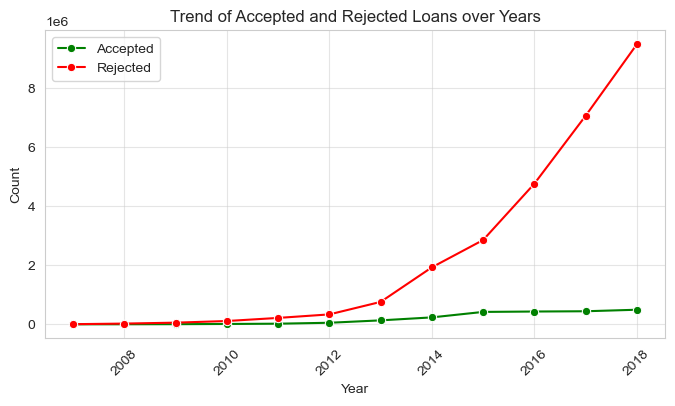

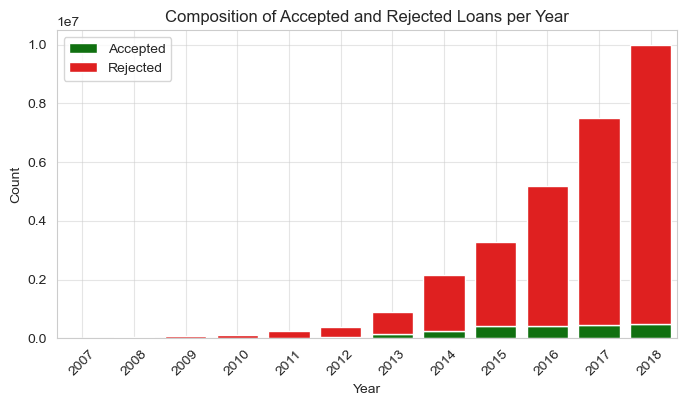

In [16]:
# line plot to visualize the trend of accepted and rejected loans over years
plt.figure(figsize=(8, 4))  
sns.lineplot(x='year', y='accepted_count', data=result, label='Accepted', marker='o', color='green')
sns.lineplot(x='year', y='rejected_count', data=result, label='Rejected', marker='o', color='red')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Trend of Accepted and Rejected Loans over Years')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5)
plt.show()

# stacked bar plot to compare the composition of accepted and rejected loans per year
plt.figure(figsize=(8, 4))  
sns.barplot(x='year', y='accepted_count', data=result, label='Accepted', color='green')
sns.barplot(x='year', y='rejected_count', data=result, label='Rejected', color='red', bottom=result['accepted_count'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Composition of Accepted and Rejected Loans per Year')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5)
plt.show()

- We can see much higher in frequency of rejcted loans. 
- Not sure if the data started being summed up from zero somehow, misguiding us in a way.

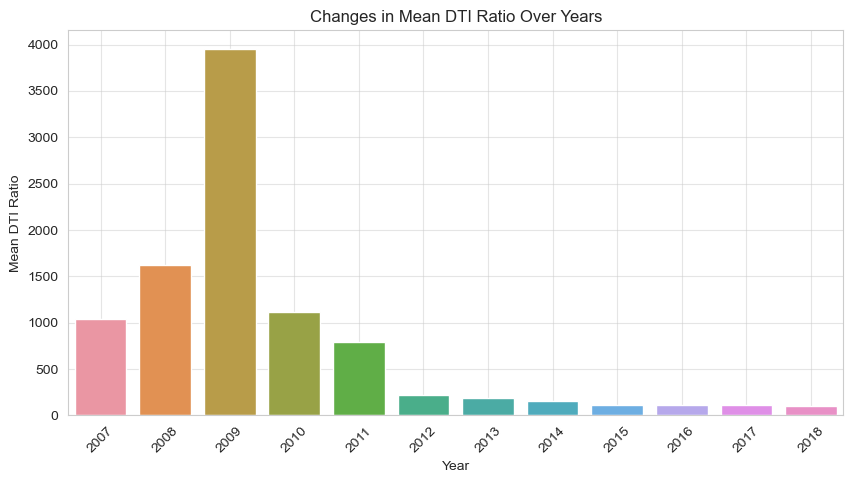

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='dti_mean', data=result)
plt.xlabel('Year')
plt.ylabel('Mean DTI Ratio')
plt.title('Changes in Mean DTI Ratio Over Years')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5)
plt.show()

- We can see 2008 and 2009 effect of financial crisis increasing the DTI mean probably. 
- Other years are different mostly from this cluster arround 2009.
- This 'effect' being lost in 2012. So 3-4 years if debt burden it seems in a way.

In [18]:
result['dti_mean']

0    1034.65
1    1621.96
2    3955.67
3    1112.84
4     788.15
5     222.93
6     184.88
7     154.78
8     106.60
9     114.00
10    112.37
11    100.49
Name: dti_mean, dtype: float64

### Statistical test to compare dti means per year 

In [19]:
data_for_test = result[['year', 'dti_mean']]

In [20]:
# Checking for normal distribution
normal_test_result = stats.shapiro(data_for_test['dti_mean'])
print("Shapiro-Wilk Test for Normality: ", normal_test_result)

Shapiro-Wilk Test for Normality:  ShapiroResult(statistic=0.6749727725982666, pvalue=0.0004888694384135306)


In [21]:
# Checking for equal variances
levene_test_result = stats.levene(data_for_test[data_for_test['year'].isin([2008, 2009])]['dti_mean'],
                                  data_for_test[~data_for_test['year'].isin([2008, 2009])]['dti_mean'])
print("Levene's Test for Equal Variances: ", levene_test_result)

Levene's Test for Equal Variances:  LeveneResult(statistic=10.353838728934658, pvalue=0.00921039597416363)


In [22]:
kruskal_result = stats.kruskal(data_for_test[data_for_test['year'].isin([2008, 2009])]['dti_mean'],
                               data_for_test[~data_for_test['year'].isin([2008, 2009])]['dti_mean'])
print("Kruskal-Wallis Test Result: ", kruskal_result)

Kruskal-Wallis Test Result:  KruskalResult(statistic=4.61538461538462, pvalue=0.03168638853979348)


Since the p-value (0.03168638853979348) is less than 0.05, reject the null hypothesis. This suggests that there is a statistically significant difference in the mean DTI ratios between the years 2008 and 2009 and the other years in your dataset.
The result indicates that the financial conditions in 2008 and 2009 (likely influenced by the financial crisis) were significantly different from other years in terms of the DTI ratios.

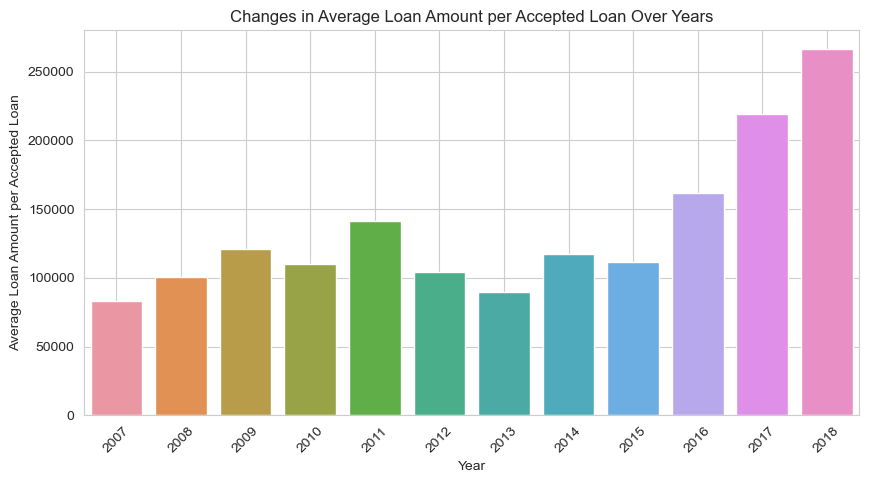

In [23]:
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='avg_loan_per_accepted', data=result)
plt.xlabel('Year')
plt.ylabel('Average Loan Amount per Accepted Loan')
plt.title('Changes in Average Loan Amount per Accepted Loan Over Years')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

- We can see loan amount of accpeted loans increasing after 2014 sharply.

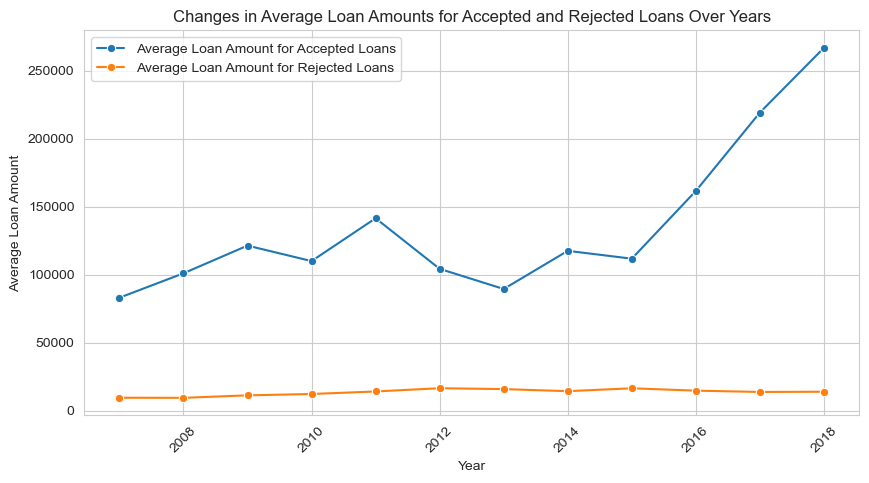

In [24]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='avg_loan_per_accepted', data=result, marker='o', label='Average Loan Amount for Accepted Loans')
sns.lineplot(x='year', y='avg_loan_per_rejected', data=result, marker='o', label='Average Loan Amount for Rejected Loans')
plt.xlabel('Year')
plt.ylabel('Average Loan Amount')
plt.title('Changes in Average Loan Amounts for Accepted and Rejected Loans Over Years')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

- We can see that rejected loans on average ar e  much lower than accepted loans.
- We see stable loan amount for rejected ones, but mor variable and later increasing accpeted loan amount. 

In [25]:
data_combined.groupby('loan_status')['loan_amnt'].mean()

loan_status
0   13133.24
1   15046.93
Name: loan_amnt, dtype: float64

- Mean difference in loan amounts for approved and rejected

### Statistical test for means of rejected vs accepted loans
H0: means are same
H1: means are not the same

In [26]:
accepted_loans = data_combined[data_combined['loan_status'] == 1]['loan_amnt']
rejected_loans = data_combined[data_combined['loan_status'] == 0]['loan_amnt']

In [27]:
accepted_loans.isnull().sum()

33

In [28]:
accepted_loans.dropna(inplace=True)

C:\Users\Martin\AppData\Local\Temp\ipykernel_25632\2713814259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted_loans.dropna(inplace=True)


In [29]:
accepted_loans.isnull().sum()

0

In [30]:
rejected_loans.isnull().sum()

0

In [33]:
# Normality check (can be skipped for large samples)
print("Normality Test (Accepted Loans): ", shapiro(accepted_loans))
print("Normality Test (Rejected Loans): ", shapiro(rejected_loans))

C:\Users\Martin\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Normality Test (Accepted Loans):  ShapiroResult(statistic=0.935567319393158, pvalue=0.0)
Normality Test (Rejected Loans):  ShapiroResult(statistic=0.640223503112793, pvalue=0.0)


In [34]:
# Equality of variances
from scipy.stats import levene
print("Levene's Test: ", levene(accepted_loans, rejected_loans))

Levene's Test:  LeveneResult(statistic=27228.831173487786, pvalue=0.0)


- Accepted Loans: The test statistic is 0.935567319393158 and the p-value is 0.0. The low p-value indicates that the loan amounts for accepted loans do not follow a normal distribution.
- Rejected Loans: The test statistic is 0.640223503112793 and the p-value is 0.0. This also indicates a deviation from normal distribution for rejected loans.

Levene's Test for Equality of Variances:

The Levene's test statistic is 27228.831173487786 and the p-value is 0.0. This indicates a significant difference in the variances of the loan amounts between accepted and rejected loans.

In [35]:
# Welch's T-Test
t_test_result = ttest_ind(accepted_loans, rejected_loans, equal_var=False)
print("Welch's T-Test Result: ", t_test_result)

Welch's T-Test Result:  TtestResult(statistic=283.6758291347997, pvalue=0.0, df=3341287.185353753)


- Given that the p-value is significantly lower than any standard alpha level (e.g., 0.05), reject the null hypothesis.
- This implies that there is a statistically significant difference in the mean loan amounts between loans that are accepted and those that are rejected.
- The large test statistic further strengthens the conclusion that this difference is not only statistically significant but also likely to be practically significant.

## Aggregation by states

In [36]:
def mode(x):
    return x.mode().iloc[0] if len(x) > 0 else None

agg_funcs = {
    'loan_status': ['sum', 'mean'],
    'loan_amnt': ['mean'],
    'emp_length': mode,
    'dti': 'mean'
}

state_agg = data_combined.groupby('addr_state').agg(agg_funcs)
state_agg.columns = ['accepted_count', 'acceptance_rate', 'mean_loan_amnt_accepted', 'mode_emp_length', 'mean_dti']
state_agg['rejected_count'] = data_combined[data_combined['loan_status'] == 0].groupby('addr_state')['loan_status'].count()
state_agg['mean_loan_amnt_rejected'] = data_combined[data_combined['loan_status'] == 0].groupby('addr_state')['loan_amnt'].mean()
state_agg.reset_index(inplace=True)

In [37]:
state_agg.shape

(51, 8)

In [38]:
state_agg.head()

,addr_state,accepted_count,acceptance_rate,mean_loan_amnt_accepted,mode_emp_length,mean_dti,rejected_count,mean_loan_amnt_rejected
0,AK,5231,0.08,15312.28,< 1 year,106.48,60427,15141.48
1,AL,27284,0.05,11939.56,< 1 year,121.07,493226,11787.63
2,AR,17074,0.06,12749.73,< 1 year,128.18,291237,12670.88
3,AZ,53777,0.08,13136.91,< 1 year,135.42,588880,13010.39
4,CA,314533,0.09,14040.28,< 1 year,146.62,3242169,13919.27


In [39]:
state_agg['total_count'] = state_agg['accepted_count'] + state_agg['rejected_count']
state_agg['acceptance_rate_per_state'] = state_agg['accepted_count'] / state_agg['total_count']
state_agg['rejection_rate_per_state'] = state_agg['rejected_count'] / state_agg['total_count']

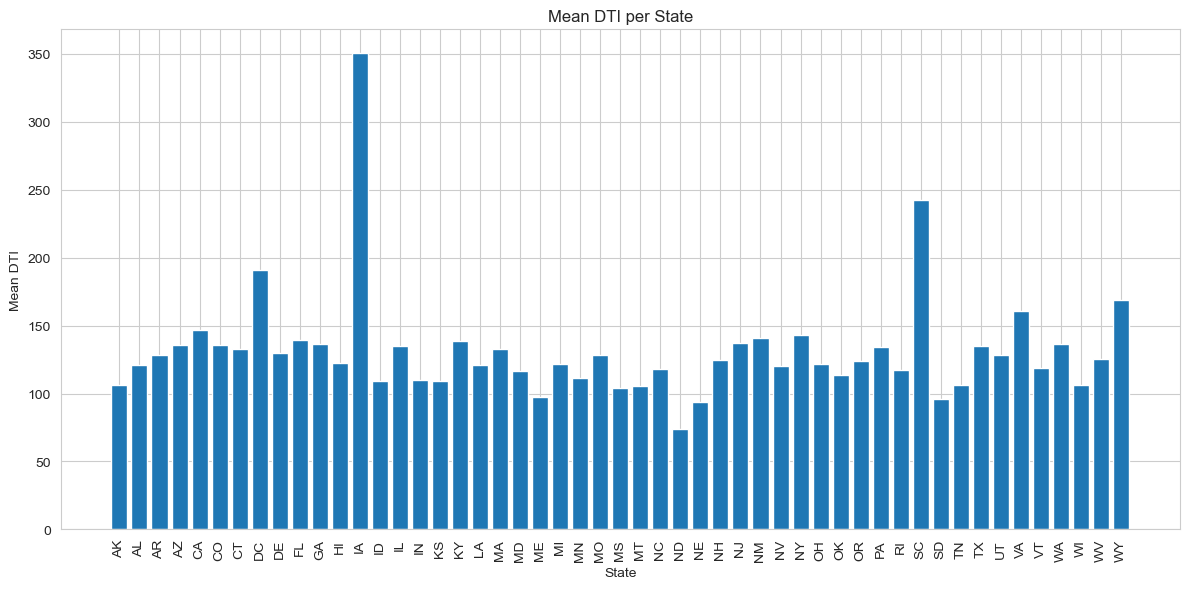

In [40]:
states = state_agg['addr_state']
mean_dti = state_agg['mean_dti']
plt.figure(figsize=(12, 6))
plt.bar(states, mean_dti)
plt.xlabel('State')
plt.ylabel('Mean DTI')
plt.title('Mean DTI per State')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- We can see some states jumping out with mean DTI. IA, SC primarily

In [41]:
data_remove_duplicates = data_combined.drop_duplicates()

In [42]:
loan_counts_before = data_combined['loan_status'].value_counts()
loan_counts_after = data_remove_duplicates['loan_status'].value_counts()
rejected_diff = loan_counts_before[0] - loan_counts_after[0]  # Duplicates in rejected loans
accepted_diff = loan_counts_before[1] - loan_counts_after[1]  # Duplicates in accepted loans
print(f"Duplicates in Rejected Loans: {rejected_diff}")
print(f"Duplicates in Accepted Loans: {accepted_diff}")

Duplicates in Rejected Loans: 2666208
Duplicates in Accepted Loans: 892


In [43]:
data_remove_duplicates.isnull().sum()

loan_amnt               1
dti                  1687
zip_code              268
addr_state             21
emp_length        1068219
year                    1
loan_status             0
title_category     161887
dtype: int64

In [44]:
data_removed_na_dup = data_remove_duplicates.dropna()

In [45]:
# Saving two files
data_removed_na_dup.to_csv('./Datasets/Data_Removed_NaN_and_Duplicates.csv', index=False)
data_remove_duplicates.to_csv('./Datasets/Data_without_duplicates_with_NaN.csv', index=False)